# **🧠 Face Detection and Clustering**

# **🔍 Objective (Simple & Human-Friendly)**
1. To detect faces in images and group similar ones together automatically.

2. To organize photos by identifying and clustering similar faces.

3. To build a simple system that finds faces and sorts them by who they look like.

4. To help manage photo collections by grouping faces of the same person.

5. To explore how machines can recognize and group faces without knowing names.



# **Install Libraries**
# **Import Dependencies**

In [1]:
# Install any missing libraries (uncomment if not already installed)
!pip install scikit-image opencv-python-headless seaborn --quiet

# Imports
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import hog  # from scikit-image

import PIL
import cv2
import pickle


# **Upload, Process, and Visualize HOG Features**

Saving Gloria_Macapagal_Arroyo_0010.jpg to Gloria_Macapagal_Arroyo_0010.jpg
Saving Gloria_Macapagal_Arroyo_0011.jpg to Gloria_Macapagal_Arroyo_0011.jpg
Saving Halle_Berry_0002.jpg to Halle_Berry_0002.jpg
Saving Halle_Berry_0005.jpg to Halle_Berry_0005.jpg
Saving Halle_Berry_0007.jpg to Halle_Berry_0007.jpg
Saving Halle_Berry_0010.jpg to Halle_Berry_0010.jpg
Saving Halle_Berry_0011.jpg to Halle_Berry_0011.jpg
Saving Halle_Berry_0012.jpg to Halle_Berry_0012.jpg
Saving Halle_Berry_0015.jpg to Halle_Berry_0015.jpg
Saving Halle_Berry_0016.jpg to Halle_Berry_0016.jpg
Saving Colin_Powell_0124.jpg to Colin_Powell_0124.jpg
Saving Colin_Powell_0126.jpg to Colin_Powell_0126.jpg


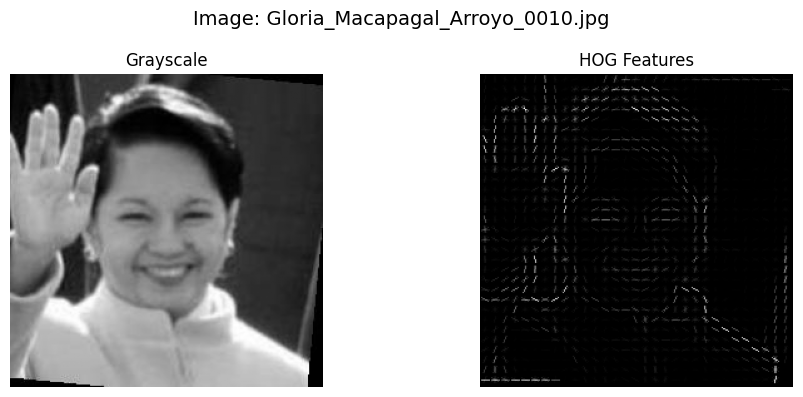

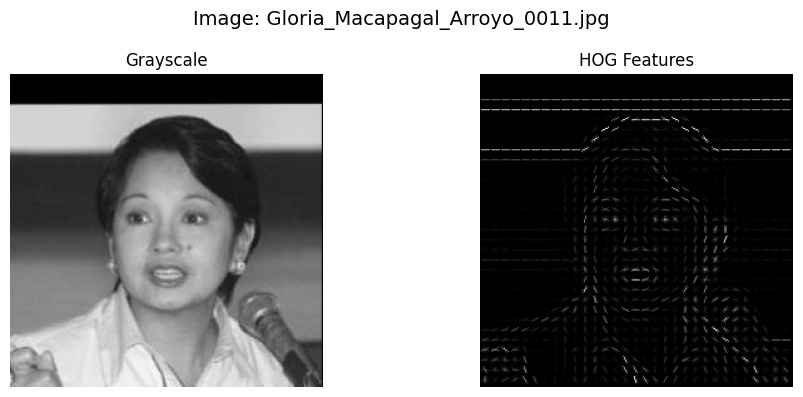

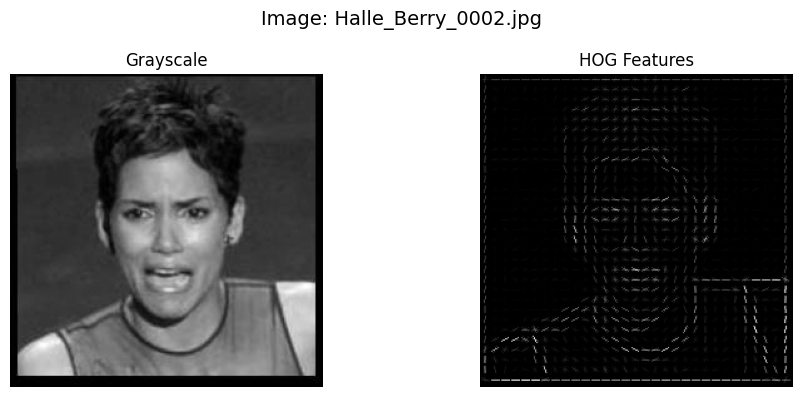

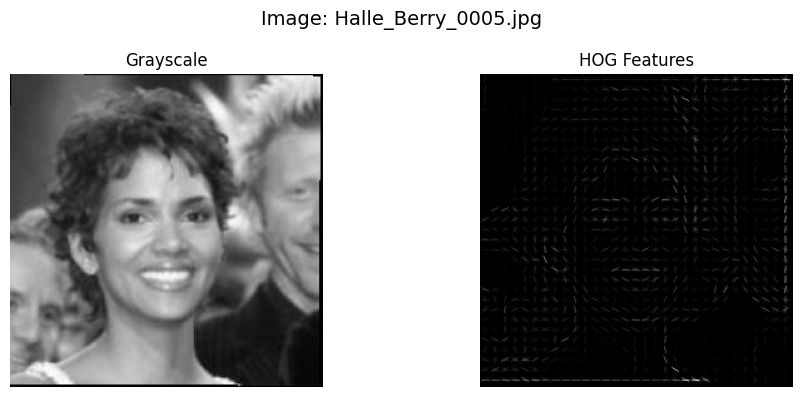

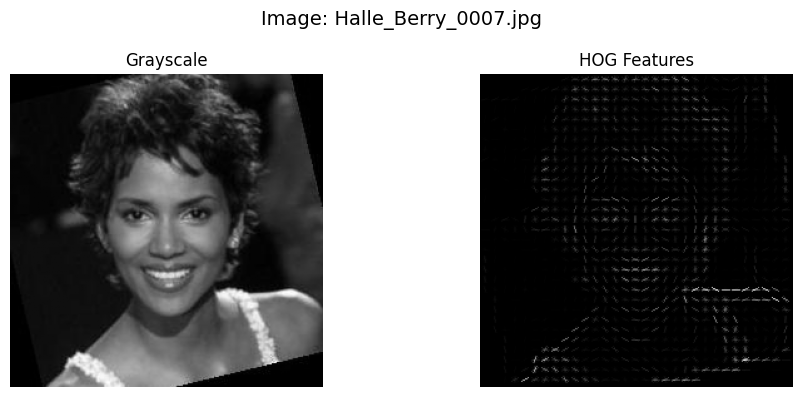

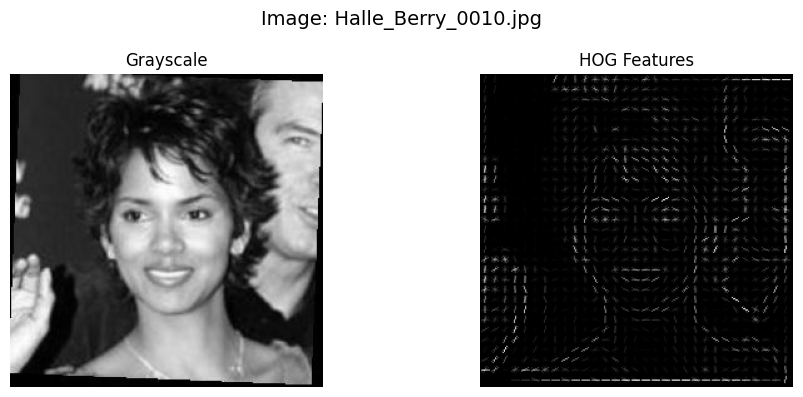

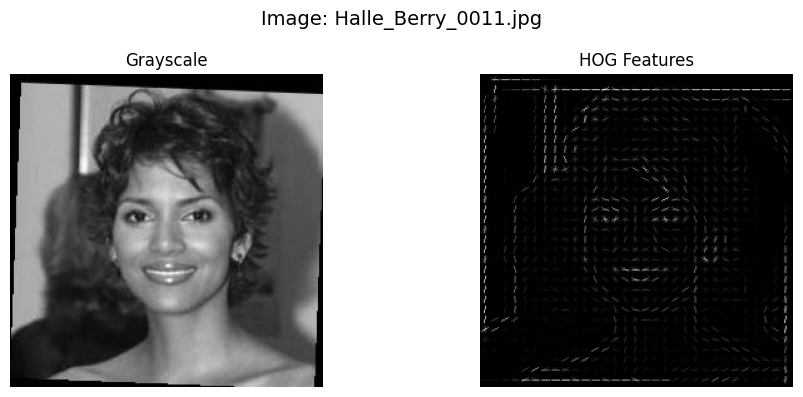

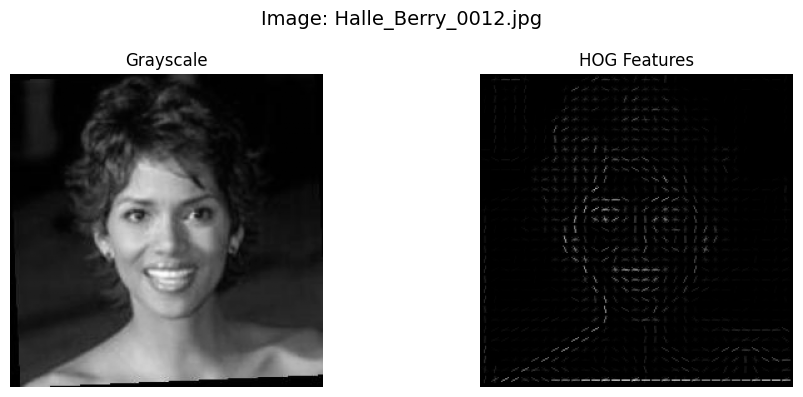

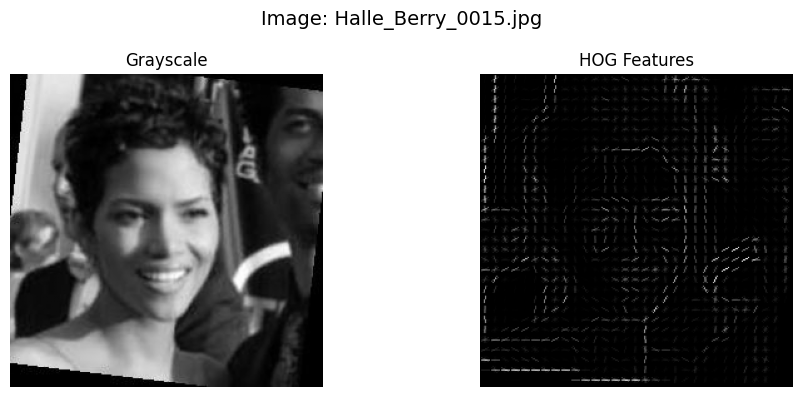

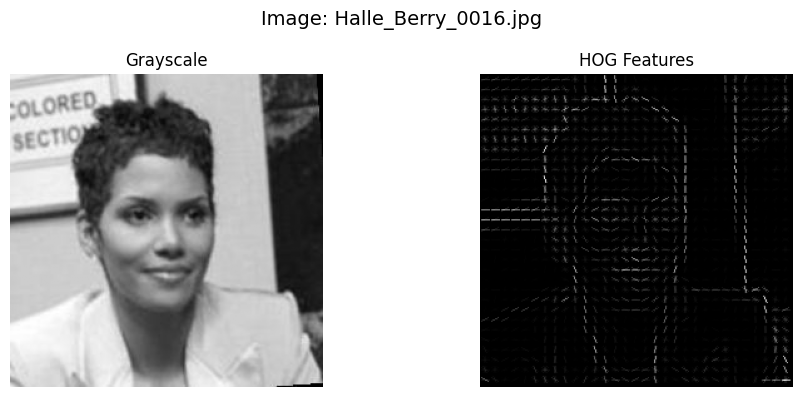

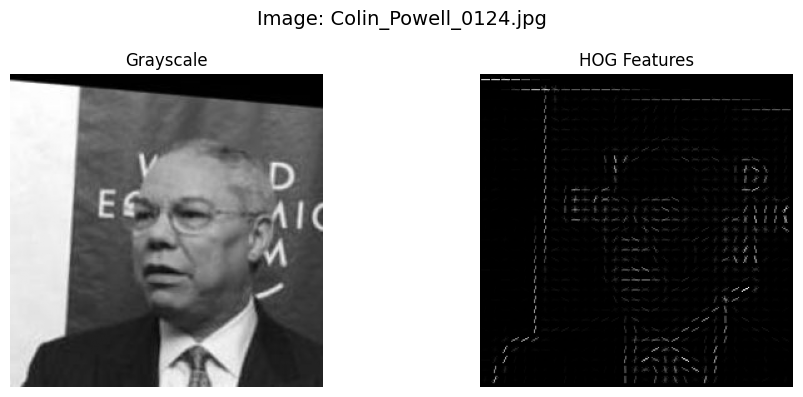

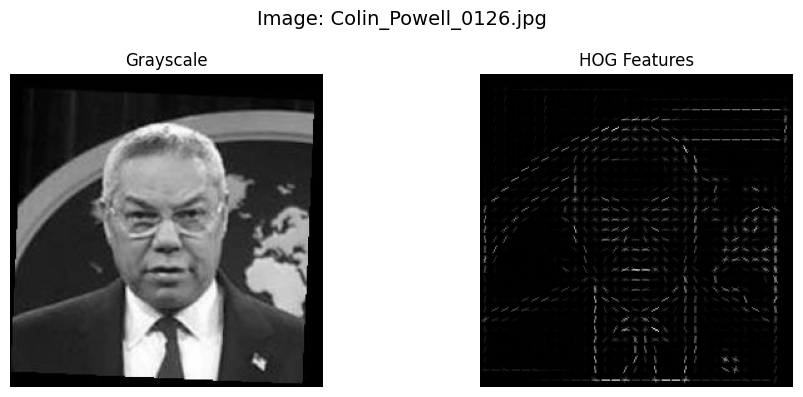

In [2]:
from google.colab import files

# Upload multiple images
uploaded = files.upload()

# Loop through all uploaded images
for i, (img_name, data) in enumerate(uploaded.items()):
    # Load image and convert to grayscale
    image = np.asarray(PIL.Image.open(img_name).convert('L'))

    # Get HOG features and visualization
    hog_features, visualized = hog(image,
                                   orientations=9,
                                   pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2),
                                   visualize=True)

    # Display both grayscale and HOG image
    fig = plt.figure(figsize=(10, 4))

    fig.suptitle(f"Image: {img_name}", fontsize=14)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image, cmap='gray')
    ax1.set_title("Grayscale")
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(visualized, cmap='gray')
    ax2.set_title("HOG Features")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


# **Process Positive Images and Extract HOG Features**

In [3]:
pos_images = []

# Loop through the uploaded images (dictionary)
for img_name, img_data in uploaded.items():
    # Load image with PIL, convert to grayscale
    img = np.asarray(PIL.Image.open(img_name).convert('L'))

    # Resize to 128x128
    img = cv2.resize(img, (128, 128))

    # Extract HOG features (no visualization needed here)
    hog_features = hog(img,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       visualize=False)

    # Append to positive image list
    pos_images.append(hog_features)

print(f"Total positive images processed: {len(pos_images)}")

Total positive images processed: 12


# **Process and Sort Positive Images for HOG Features**

In [4]:
pos_images = []

# Loop through sorted uploaded image names
for img_name in sorted(uploaded.keys()):
    # Load image with PIL, convert to grayscale
    img = np.asarray(PIL.Image.open(img_name).convert('L'))

    # Resize to 128x128
    img = cv2.resize(img, (128, 128))

    # Extract HOG features (no visualization needed here)
    hog_features = hog(img,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       visualize=False)

    # Append to positive image list
    pos_images.append(hog_features)

print(f"Total positive images processed: {len(pos_images)}")

Total positive images processed: 12


In [6]:
pos_labels = np.ones(len(pos_images))

# **Generate and Process Negative Images**

In [56]:
# Simulate 18 random grayscale "negative" images (non-face)
neg_images = []

for _ in range(18):
    # Create a random 128x128 grayscale image
    img = np.random.randint(0, 256, (128, 128), dtype=np.uint8)

    # Extract HOG features
    hog_features = hog(img,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       visualize=False)

    neg_images.append(hog_features)

print(f"Generated {len(neg_images)} negative images.")

Generated 18 negative images.


In [57]:
pos_labels = np.ones(len(pos_images))
neg_labels = np.zeros(len(neg_images))

# **Prepare Data for Training and Testing**

In [58]:
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


# **Train SVM Classifier and Evaluate Accuracy**

In [59]:
svc = SVC()
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
print("Accuracy score of model is ",accuracy_score(y_pred=y_pred,y_true=y_test)*100)

Accuracy score of model is  100.0


In [60]:
def slideExtract(image, windowSize=(128, 128), channel="RGB", step=10):
    # Convert image to grayscale
    if channel.upper() == "RGB":
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif channel.upper() == "BGR":
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif channel.lower() in ["grayscale", "gray"]:
        img = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise Exception(" Invalid channel type. Choose from 'RGB', 'BGR', 'gray', or 'grayscale'.")

    coords = []
    features = []

    hIm, wIm = img.shape[:2]

    for w1, w2 in zip(range(0, wIm - windowSize[0], step), range(windowSize[0], wIm, step)):
        for h1, h2 in zip(range(0, hIm - windowSize[1], step), range(windowSize[1], hIm, step)):
            window = img[h1:h2, w1:w2]

            # Ensure the window is the correct size before extracting features
            if window.shape[0] == windowSize[1] and window.shape[1] == windowSize[0]:
                hog_features = hog(window,
                                   orientations=9,
                                   pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2),
                                   visualize=False)
                coords.append((w1, w2, h1, h2))
                features.append(hog_features)

    return coords, np.asarray(features)


# **Generate and Update Heatmap for Image Regions**

In [61]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    def __init__(self, original_image):
        # Heatmap mask initialized with zeros (grayscale)
        self.mask = np.zeros(original_image.shape[:2])

    def incValOfReg(self, coords):
        """Increase 'heat' in the given region"""
        w1, w2, h1, h2 = coords
        self.mask[h1:h2, w1:w2] += 10

    def decValOfReg(self, coords):
        """Decrease 'heat' in the given region"""
        w1, w2, h1, h2 = coords
        self.mask[h1:h2, w1:w2] -= 10
        # Optional: Prevent negative values
        self.mask[self.mask < 0] = 0

    def compileHeatmap(self):
        """Normalize and threshold the heatmap for visualization"""
        # Scale between 0 and 1
        scaler = MinMaxScaler()
        self.mask = scaler.fit_transform(self.mask)

        # Scale between 0 and 255
        self.mask = (self.mask * 255).astype(np.uint8)

        # Threshold the mask: highlight high-heat areas
        self.mask = cv2.inRange(self.mask, 40, 255)

        return self.mask


# **Detect Faces and Draw Bounding Boxes**

In [62]:
def detect(image):
    # Step 1: Extract sliding window features
    coords, features = slideExtract(image)
    htmp = Heatmap(image)

    # Step 2: Predict each window and update heatmap
    for i in range(len(features)):
        decision = svc.predict([features[i]])
        if decision[0] == 1:
            htmp.incValOfReg(coords[i])
        else:
            htmp.decValOfReg(coords[i])

    # Step 3: Compile heatmap and find contours
    mask = htmp.compileHeatmap()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Draw bounding boxes on original image
    output_img = image.copy()

    for c in contours:
        if cv2.contourArea(c) < 100:  # Ignoring very small detections
            continue
        x, y, w, h = cv2.boundingRect(c)
        print(f"Detected region: x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return output_img


# **Run Detection and Display Results**

Detected region: x=0, y=20, w=248, h=208


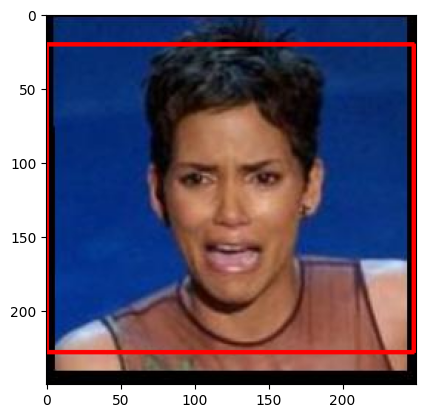

In [25]:
detected = detect(np.asarray(PIL.Image.open("/content/Halle_Berry_0002.jpg")))
plt.imshow(detected)

Detected region: x=0, y=20, w=248, h=208


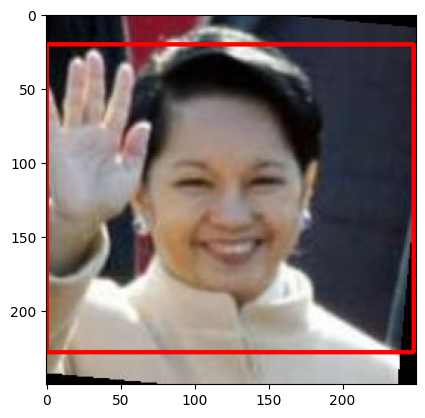

In [26]:
detected = detect(np.asarray(PIL.Image.open("/content/Gloria_Macapagal_Arroyo_0010.jpg")))
plt.imshow(detected)

In [27]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# **Detect Faces Using Haar Cascade Classifier**

In [29]:
imagePath = '/content/Gloria_Macapagal_Arroyo_0010.jpg'
img = cv2.imread(imagePath)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = face_classifier.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60)
)
print("The cordinates of the formed bouding boxes are in the form (x,y,w,h)")
for (x, y, w, h) in face:
    print(x, y, w, h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

The cordinates of the formed bouding boxes are in the form (x,y,w,h)
63 65 124 124


# **Display Detected Faces on Image**

(np.float64(-0.5), np.float64(249.5), np.float64(249.5), np.float64(-0.5))

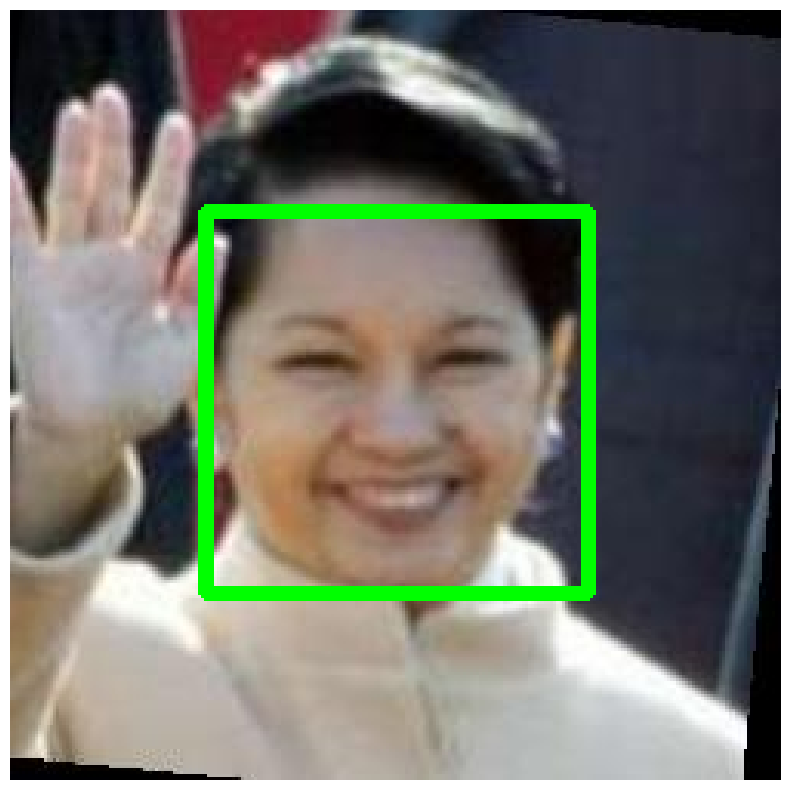

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')

# **Draw Bounding Boxes and Display Final Image**

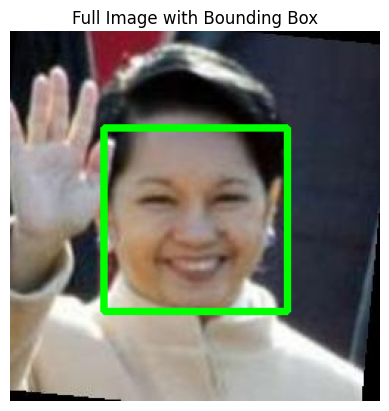

In [33]:
cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Full Image with Bounding Box")
plt.show()

# **Face Detection and Cropping Using Haar Cascade Classifier in OpenCV**

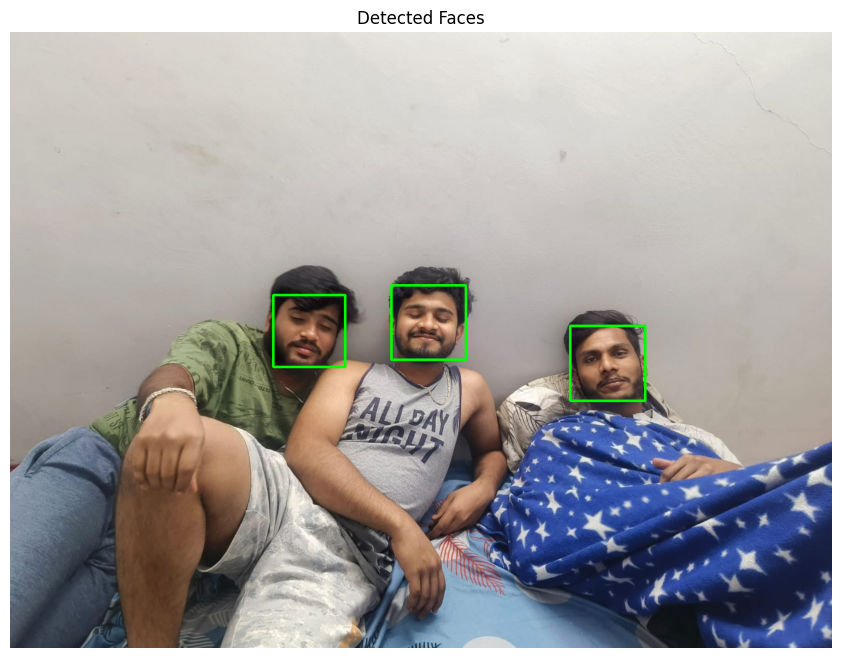

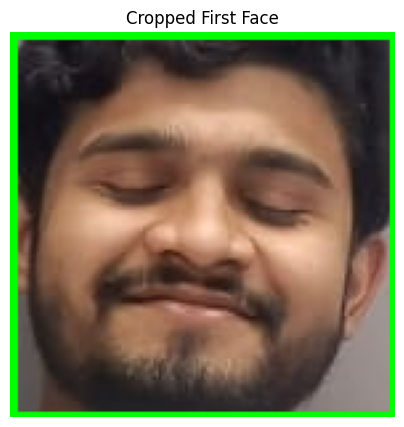

In [54]:
# Load the uploaded image
imagePath = '/content/789.jpg'
img = cv2.imread(imagePath)

# Convert the image to grayscale
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_classifier.detectMultiScale(
    gray_image,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(60, 60)
)

# Draw bounding boxes on detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)

# Convert to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display image with face detections
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detected Faces")
plt.show()

# Crop and display the first detected face
if len(faces) > 0:
    x, y, w, h = faces[0]
    cropped_face = img[y:y+h, x:x+w]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_face_rgb)
    plt.axis('off')
    plt.title("Cropped First Face")
    plt.show()
else:
    print("No faces detected.")


# **SSIM Calculation Between Two Images with Bounding Box**

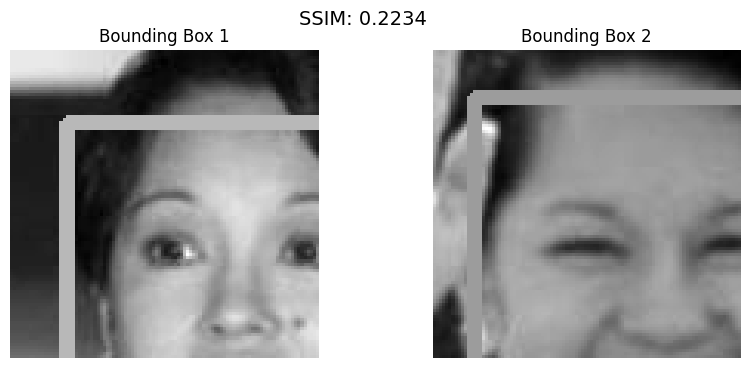

 Structural Similarity Index (SSIM): 0.22336885095792514


In [65]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2

def calculate_ssim(image1, image2):
    # Convert both to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Resize to smallest common size
    min_height = min(image1_gray.shape[0], image2_gray.shape[0])
    min_width = min(image1_gray.shape[1], image2_gray.shape[1])
    image1_resized = cv2.resize(image1_gray, (min_width, min_height))
    image2_resized = cv2.resize(image2_gray, (min_width, min_height))

    # Compute SSIM
    ssim_index, _ = ssim(image1_resized, image2_resized, full=True)
    return ssim_index, image1_resized, image2_resized

# Ensure both bounding boxes exist
if 'bounding_box_image_2' in locals() and 'bounding_box_image' in locals():
    ssim_value, img1_gray, img2_gray = calculate_ssim(bounding_box_image_2, bounding_box_image)

    # Plot both grayscale images
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_gray, cmap='gray')
    plt.title("Bounding Box 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_gray, cmap='gray')
    plt.title("Bounding Box 2")
    plt.axis('off')

    plt.suptitle(f"SSIM: {ssim_value:.4f}", fontsize=14)
    plt.show()

    print(" Structural Similarity Index (SSIM):", ssim_value)
else:
    print(" One or both bounding box images are not defined.")


# **Custom vs Skimage SSIM Calculation for Bounding Boxes**

 SSIM using skimage: 0.2234
 Custom SSIM implementation: 0.6251


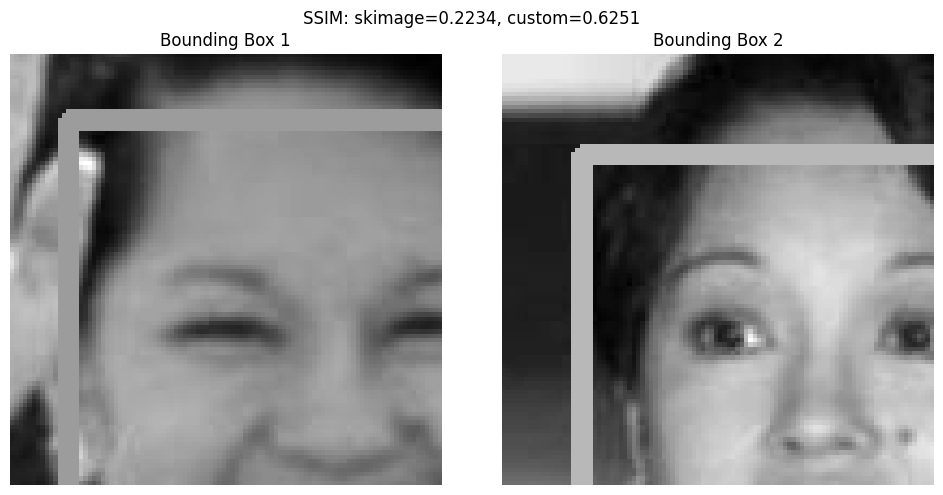

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_skimage

# Constants for SSIM
K1 = 0.01
K2 = 0.03
K3 = 0.05

# Helper Functions
def luminance(image):
    return np.mean(image)

def contrast(image):
    mu = luminance(image)
    variance = np.var(image)
    return variance / (mu**2 + K1)

def gaussian_filter(image, sigma=1.5):  # 1.5 gives smoother results than using K2
    return cv2.GaussianBlur(image, (15, 15), sigma)

def structure(image1, image2):
    filtered1 = gaussian_filter(image1)
    filtered2 = gaussian_filter(image2)

    mu1 = luminance(filtered1)
    mu2 = luminance(filtered2)

    sigma1 = np.var(filtered1)
    sigma2 = np.var(filtered2)
    sigma12 = np.mean((filtered1 - mu1) * (filtered2 - mu2))

    return sigma12 / (np.sqrt(sigma1 * sigma2) + K2)

def ssim_custom(image1, image2):
    L1, L2 = luminance(image1), luminance(image2)
    C1, C2 = contrast(image1), contrast(image2)
    S12 = structure(image1, image2)

    L = (2 * L1 * L2 + K1) / (L1**2 + L2**2 + K1)
    C = (2 * C1 * C2 + K2) / (C1**2 + C2**2 + K2)
    S = S12 / (S12 + K3)

    return L * C * S

# --- Main Execution ---

# Convert both bounding boxes to grayscale and resize
im1 = cv2.cvtColor(bounding_box_image, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(bounding_box_image_2, cv2.COLOR_BGR2GRAY)

min_height = min(im1.shape[0], im2.shape[0])
min_width = min(im1.shape[1], im2.shape[1])

im1 = cv2.resize(im1, (min_width, min_height))
im2 = cv2.resize(im2, (min_width, min_height))

# SSIM Comparisons
ssim_value_skimage = ssim_skimage(im1, im2)
ssim_value_custom = ssim_custom(im1, im2)

# Output
print(" SSIM using skimage:", round(ssim_value_skimage, 4))
print(" Custom SSIM implementation:", round(ssim_value_custom, 4))

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title("Bounding Box 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray')
plt.title("Bounding Box 2")
plt.axis('off')

plt.suptitle(f"SSIM: skimage={ssim_value_skimage:.4f}, custom={ssim_value_custom:.4f}")
plt.tight_layout()
plt.show()


# **Image Matching Using SIFT and FLANN for Similarity Detection**

1
Images are not similar.


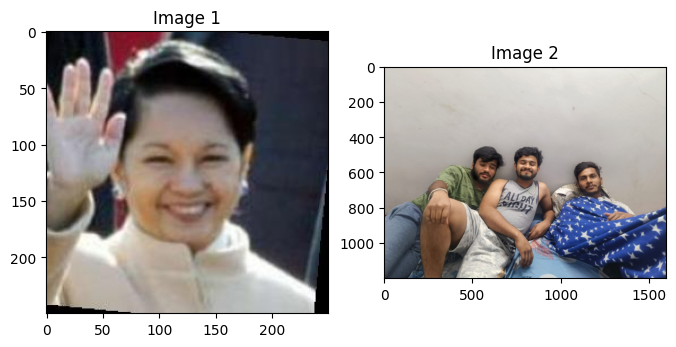

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_matching(img1, img2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect key points and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        print("Descriptors not found in one of the images.")
        return

    # FLANN parameters
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(des1, des2, k=2
                             )

    # ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    print(len(good_matches))
    min_good_matches = 5 # Adjust this threshold as needed
    if len(good_matches) >= min_good_matches:
        print("Images are similar.")
    else:
        print("Images are not similar.")

    # Display images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title("Image 1")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title("Image 2")
    plt.show()


# === MAIN EXECUTION STARTS HERE ===
img1 = cv2.imread("/content/Gloria_Macapagal_Arroyo_0010.jpg")
img2 = cv2.imread("/content/789.jpg")

if img1 is None or img2 is None:
    print("Error loading one or both images. Check file paths.")
else:
    image_matching(img1, img2)


# **Face Detection and Clustering of Uploaded Images**

In [94]:
# STEP 1: Install & import dependencies
import cv2
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
uploaded = files.upload()

# Create /content/images folder and move uploaded files
os.makedirs("/content/images", exist_ok=True)
for filename in uploaded.keys():
    shutil.move(filename, os.path.join("/content/images", filename))

# Define paths
folder_path = '/content/images'
cluster_folder_directory = '/content/clustered_faces'

# STEP 2: Define required functions

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("Could not read image:", img_path)
        return []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))
    face_images = []
    for (x, y, w, h) in faces:
        face_image = img[y:y+h, x:x+w]
        face_images.append(face_image)
    return face_images

def image_matching(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return 1 if len(good_matches) >= 5 else 0

def get_clusters(similarity):
    num_images = similarity.shape[0]
    clusters = {}
    image_hash = np.zeros(num_images)
    for i in range(len(image_hash)):
        if image_hash[i] == 0:
            clusters[i] = []
            image_hash[i] = 1
            for j in range(num_images):
                if i == j or image_hash[j] == 1:
                    continue
                if similarity[i][j] == 1:
                    clusters[i].append(j)
                    image_hash[j] = 1
    return clusters

def generate_data(folder_path):
    index = 0
    face_to_index = []
    all_faces = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        faces = detect_faces(image_path)
        all_faces += faces
        face_to_index += [index for _ in range(len(faces))]
        index += 1

    n = len(all_faces)
    similarity = np.ones((n, n))
    for i in range(n):
        for j in range(i+1, n):
            similarity[i][j] = image_matching(all_faces[i], all_faces[j])
            similarity[j][i] = similarity[i][j]
    return similarity, face_to_index, all_faces

def cluster_embeddings(similarity):
    clusters = get_clusters(similarity)
    cluster_labels = {}
    for i in clusters:
        if len(clusters[i]) == 0:
            cluster_labels[i] = -1
        else:
            cluster_labels[i] = i
            for x in clusters[i]:
                cluster_labels[x] = i
    return list(dict(sorted(cluster_labels.items())).values())

def map_images(folder_path):
    embeddings, face_to_index, all_faces = generate_data(folder_path)
    labels_faces = cluster_embeddings(embeddings)
    labels_images = {}
    for i, l in enumerate(labels_faces):
        parent_image = face_to_index[i]
        if parent_image in labels_images:
            labels_images[parent_image].append(l)
        else:
            labels_images[parent_image] = [l]
    return labels_images, labels_faces, all_faces

def copy_image(source_path, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    filename = os.path.basename(source_path)
    destination_path = os.path.join(destination_dir, filename)
    shutil.copyfile(source_path, destination_path)

def create_cluster_folder(folder_path, cluster_folder_directory):
    image_cluster, labels_faces, all_faces = map_images(folder_path)
    print("Image clusters Created.")
    print("Creating cluster-wise folders...")
    index = 0
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if index in image_cluster:
            clusters = image_cluster[index]
            for c in clusters:
                destination_path = os.path.join(cluster_folder_directory, "identity_" + str(c))
                copy_image(image_path, destination_path)
        index += 1
    return image_cluster, labels_faces, all_faces

# STEP 3: Run the clustering
image_cluster, labels_faces, all_faces = create_cluster_folder(folder_path, cluster_folder_directory)
print("Done! Clustered images are saved in:", cluster_folder_directory)


Saving Colin_Powell_0126.jpg to Colin_Powell_0126 (2).jpg
Saving Colin_Powell_0127.jpg to Colin_Powell_0127 (1).jpg
Saving David_Wells_0002.jpg to David_Wells_0002 (1).jpg
Image clusters Created.
Creating cluster-wise folders...
Done! Clustered images are saved in: /content/clustered_faces


# **Visualizing Face Clusters in Images**

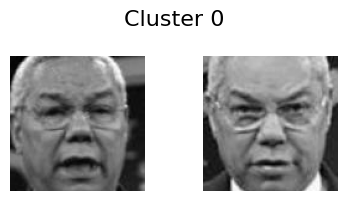

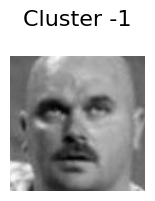

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels_faces to NumPy array if not already
labels_faces = np.array(list(labels_faces))

# Group indices of faces by cluster label
cluster_to_face = {}
for c in set(labels_faces):
    ind = np.where(labels_faces == c)[0]
    cluster_to_face[c] = ind

# Display each cluster
for c in cluster_to_face:
    ind = cluster_to_face[c]

    # Handle single-face clusters (ax is not iterable in that case)
    fig, ax = plt.subplots(1, len(ind), figsize=(2 * len(ind), 2))

    # Ensure ax is iterable
    if len(ind) == 1:
        ax = [ax]

    for i in range(len(ind)):
        ax[i].imshow(all_faces[ind[i]], cmap='gray')
        ax[i].axis('off')
    fig.suptitle(f"Cluster {c}", fontsize=16)
    plt.tight_layout()
    plt.show()


# **Displaying Images from Clustered Folders**

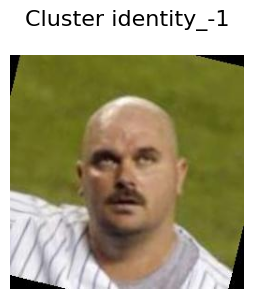

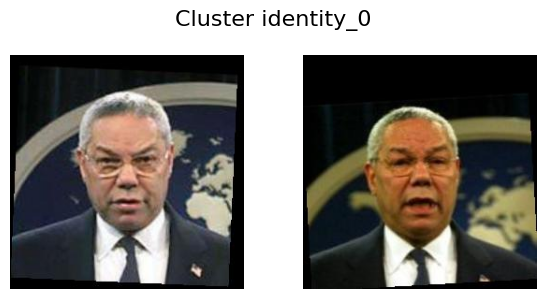

In [105]:
import os
import cv2
import matplotlib.pyplot as plt

# Path where clustered faces are saved
base_path = 'clustered_faces'

# Get list of cluster folders (sorted for consistency)
cluster_dirs = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

for cluster_name in cluster_dirs:
    cluster_path = os.path.join(base_path, cluster_name)
    image_files = sorted([f for f in os.listdir(cluster_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Skip if no images
    if not image_files:
        continue

    # Create subplot (1 row, len(images))
    fig, ax = plt.subplots(1, len(image_files), figsize=(3 * len(image_files), 3))

    # Ensure ax is iterable
    if len(image_files) == 1:
        ax = [ax]

    for i, filename in enumerate(image_files):
        img_path = os.path.join(cluster_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis('off')

    fig.suptitle(f"Cluster {cluster_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


# **Installing the imagehash Library**

In [108]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.6 MB/s eta 0:00:00


# **Detecting Duplicate Images Using Image Hashing with imagehash Library**

Saving Gloria_Macapagal_Arroyo_0011.jpg to Gloria_Macapagal_Arroyo_0011 (3).jpg
Saving Halle_Berry_0002.jpg to Halle_Berry_0002 (3).jpg
❌ No duplicates found


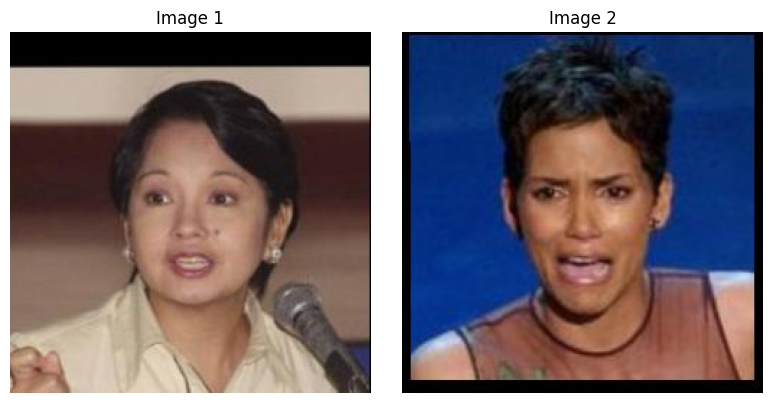

In [115]:
import imagehash
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
uploaded = files.upload()

# Get image file paths
image_paths = list(uploaded.keys())

# Ensure exactly 2 images are uploaded
if len(image_paths) != 2:
    print("Please upload exactly 2 images.")
else:
    # Open and fix orientation
    image1 = ImageOps.exif_transpose(Image.open(image_paths[0]))
    image2 = ImageOps.exif_transpose(Image.open(image_paths[1]))

    # Construct the hash
    hash1 = imagehash.average_hash(image1)
    hash2 = imagehash.average_hash(image2)

    # Calculate the hamming distance
    value = hash1 - hash2
    if value == 0:
        print(" Duplicate images detected")
    else:
        print(" No duplicates found")

    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image1)
    ax[0].set_title("Image 1")
    ax[0].axis("off")

    ax[1].imshow(image2)
    ax[1].set_title("Image 2")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


# **Detecting Duplicate Images Using Image Hashing with imagehash Library**

Saving WIN_20250410_01_09_01_Pro.jpg to WIN_20250410_01_09_01_Pro (2).jpg
Saving WIN_20250410_01_09_02_Pro.jpg to WIN_20250410_01_09_02_Pro (2).jpg
 Duplicate images detected


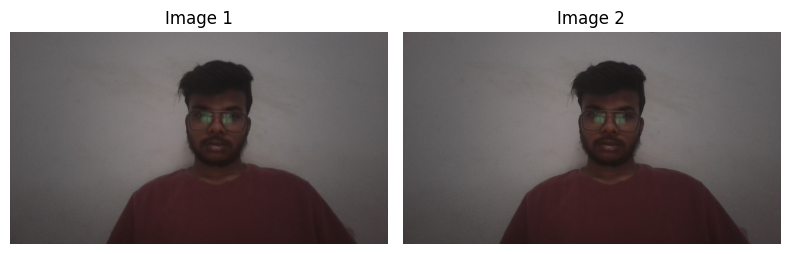

In [127]:
import imagehash
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
uploaded = files.upload()

# Get image file paths
image_paths = list(uploaded.keys())

# Ensure exactly 2 images are uploaded
if len(image_paths) != 2:
    print("Please upload exactly 2 images.")
else:
    # Open and fix orientation
    image1 = ImageOps.exif_transpose(Image.open(image_paths[0]))
    image2 = ImageOps.exif_transpose(Image.open(image_paths[1]))

    # Construct the hash
    hash1 = imagehash.average_hash(image1)
    hash2 = imagehash.average_hash(image2)

    # Calculate the hamming distance
    value = hash1 - hash2
    if value == 0:
        print(" Duplicate images detected")
    else:
        print(" No duplicates found")

    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image1)
    ax[0].set_title("Image 1")
    ax[0].axis("off")

    ax[1].imshow(image2)
    ax[1].set_title("Image 2")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
